In [1]:
import numpy as np 
from newmethods import *

In [2]:
np.random.seed(49)

In [3]:
# Generate transition matrices

def generate_poisson_transition_matrix_with_dummy_states(num_arms, num_states, num_dummy_states):
    # Initialize transition matrices
    P = np.zeros((num_arms, num_states + num_dummy_states, 2, num_states + num_dummy_states))

    for n in range(num_arms):
        # Transitions within non-dummy states (s in S)
        for s in range(num_states):
            if s == 0:
                # Boundary condition for state 0:
                P[n, s, 1, s + num_dummy_states] = np.random.rand()  # Stay in state 0
                P[n, s, 1, s + num_dummy_states + 1] = 1 - P[n, s, 1, s + num_dummy_states]  # Move to state 1
            elif s == num_states - 1:
                # Boundary condition for state 9 (last state):
                P[n, s, 1, s + num_dummy_states - 1] = np.random.rand()  # Move to state 8
                P[n, s, 1, s + num_dummy_states] = 1 - P[n, s, 1, s + num_dummy_states - 1]  # Stay in state 9
            else:
                # General case for non-boundary states
                P[n, s, 1, s + num_dummy_states - 1] = np.random.rand()  # Move to s-1
                P[n, s, 1, s + num_dummy_states + 1] = 1 - P[n, s, 1, s + num_dummy_states - 1]  # Move to s+1

            # Action 0: No pull, move to s+1, unless it's the last state
            if s < num_states - 1:
                P[n, s, 0, s + 1] = 1.0  # Move to s+1 with probability 1
            else:
                P[n, s, 0, s] = 1.0  # Stay in state 9 if it's the last state

        # Transitions within dummy states (s in S_a)
        for s_a in range(num_states, num_states + num_dummy_states):
            normal_state_index = s_a - num_states
            # Copy transitions from the corresponding normal state for action 0 within dummy states
            P[n, s_a, 0, num_states:num_states + num_dummy_states] = P[n, normal_state_index, 0, 0:num_states]
            P[n, s_a, 1, num_states:num_states + num_dummy_states] = P[n, normal_state_index, 0, 0:num_states]

    return P

In [4]:
def generate_general_transition_matrix_with_dummy_states(num_arms, num_states, num_dummy_states):
    # Initialize transition matrices
    P = np.zeros((num_arms, num_states + num_dummy_states, 2, num_states + num_dummy_states))

    for n in range(num_arms):
        # Transitions within non-dummy states (s in S)
        for s in range(num_states):
            # Action 0: Transition within S
            P[n, s, 0, :num_states] = np.random.dirichlet(np.ones(num_states))

            # Action 1: Transition to a dummy state
            P[n, s, 1, num_states:] = np.random.dirichlet(np.ones(num_dummy_states))

        # Transitions within dummy states (s in S_a)
        for s_a in range(num_states, num_states + num_dummy_states):
            # Copy transitions from the corresponding normal state for action 0
            normal_state_index = s_a - num_states
            P[n, s_a, 0, num_states:num_states+num_dummy_states] = P[n, normal_state_index, 0, 0:num_states]
            P[n, s_a, 1, num_states:num_states+num_dummy_states] = P[n, normal_state_index, 0, 0:num_states]  # Same for action 1

    return P

In [5]:
def comparison(S, N, group_member_num, K, S_prime, A, T, num_simulations = 20000, type = 'General'):
    # Define the reward function, from state 0 (reward 10) to state 9 (reward 1)
    r = np.array(list(range(S, 0, -1)) + list(range(S, 0, -1)))  # Non-dummy and dummy states have the same rewards
    # change here to generate different types of transition matrices
    P = generate_poisson_transition_matrix_with_dummy_states(N, S, S)
    P_original = P[:, :S, :, :S]+P[:,:S,:,S:]

    optimal_reward, fluid_reward, fluid_std,fluid_time = fluid_policy(N, T, S, S_prime, A, K, group_member_num, P, r, num_simulations)
    random_reward, random_std,random_time = random_policy(N, T, S, S_prime, A, K, group_member_num, P, r, num_simulations)
    no_pull_reward, no_pull_std,no_pull_time =  no_pull_policy(N, T, S, S_prime, A, K, group_member_num, P, r, num_simulations)
    Q_difference_reward, Q_difference_std,Q_difference_time =  Q_difference_policy(N, T, S, S_prime, A, K, group_member_num, P, r, num_simulations)
    finite_whittle_reward, finite_whittle_std,finite_whittle_time = finite_whittle_policy(N, T, S, S_prime, A, K, group_member_num, P, r, num_simulations)
    infinite_whittle_reward, infinite_whittle_std,infinite_whittle_time = infinite_whittle_policy(N, T, S, S_prime, A, K, group_member_num, P, r, num_simulations)
    original_whittle_reward, original_whittle_std,original_whittle_time = original_whittle_policy(N, T, S, A, K, group_member_num, P_original, r, num_simulations)


    experiment_synthetic_result = {
        "Optimal": (optimal_reward, None),
        "fluid": (fluid_reward, fluid_std),
        "random": (random_reward, random_std),
        "finite whittle": (finite_whittle_reward, finite_whittle_std),
        "inifinite whittle": (infinite_whittle_reward, infinite_whittle_std),
        "original whittle": (original_whittle_reward, original_whittle_std),
        "Q_difference": (Q_difference_reward, Q_difference_std),
        "no-pull": (no_pull_reward, no_pull_std)
    }
    running_time_dict = {
        "fluid": (fluid_time),
        "finite whittle": (finite_whittle_time),
        "inifinite whittle": (infinite_whittle_time),
        "original whittle": (original_whittle_time),
        "Q_difference": (Q_difference_time),
        "random": (random_time),
        "no_pull":(no_pull_time)
    }
    ## If you only collect reward when an arm is pulled,
    ## change the lower_bound_method to "random"
    plot_methods_with_confidence(experiment_synthetic_result, N, T, K, group_member_num, num_simulations, type, lower_bound_method="no-pull")
    return experiment_synthetic_result,running_time_dict

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


Solver status: optimal
Optimal value: 315.5707421802863
Average total reward over 2000 simulations: 931.338, stdev is 101.79162305053217
Number of pulls in dummy states (LP-based policy): 0
Running Time: 15.35486 seconds
Average total achieved value over 2000 simulations (Random policy): 861.9175, stdev is 92.64284668700081
running time: 0.00000 seconds
Average total achieved value over 2000 simulations (No-Pull policy): 795.351, stdev is 80.29694638527296
running time: 0.00000 seconds
Q difference (including dummy states):
Average total achieved value over 2000 simulations (General Q difference index policy): 935.702, stdev is 97.68777122200692
running time: 0.01724 seconds
Finite whittle (including dummy states):
Average total achieved value over 2000 simulations (General Finite Whittle index policy): 931.8775, stdev is 99.55627664723067
running time: 18.71853 seconds
Whittle Indices (including dummy states):
Average total achieved value over 2000 simulations (General Infinite Whittl

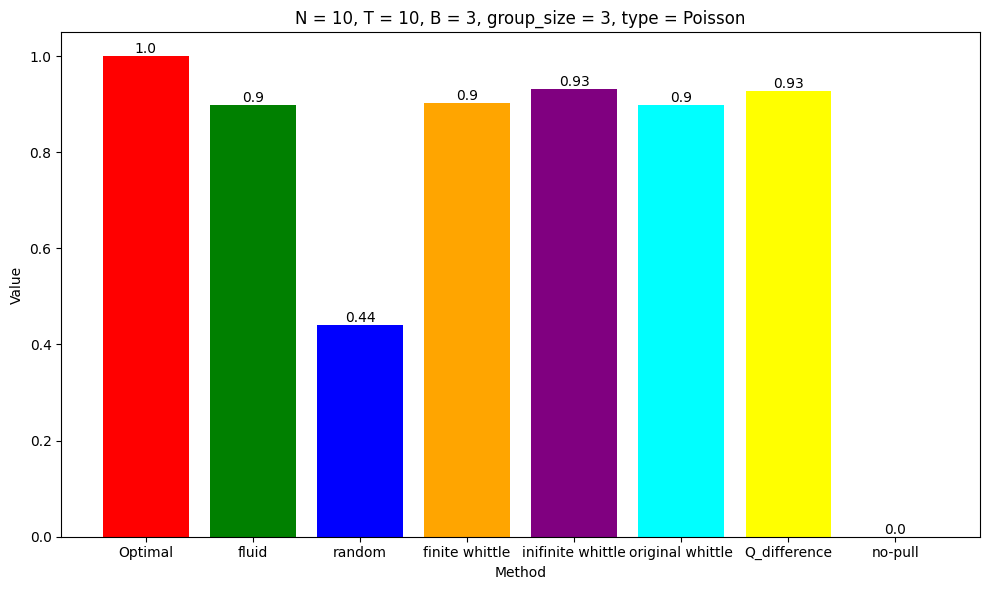

In [6]:
S = 10
N = 10
group_member_num = 3
K = 3
S_prime = S * 2
A = 2
T = 10
num_simulations = 2000
test_result,runningtime_result=comparison(S, N, group_member_num, K, S_prime, A, T, num_simulations, 'Poisson')

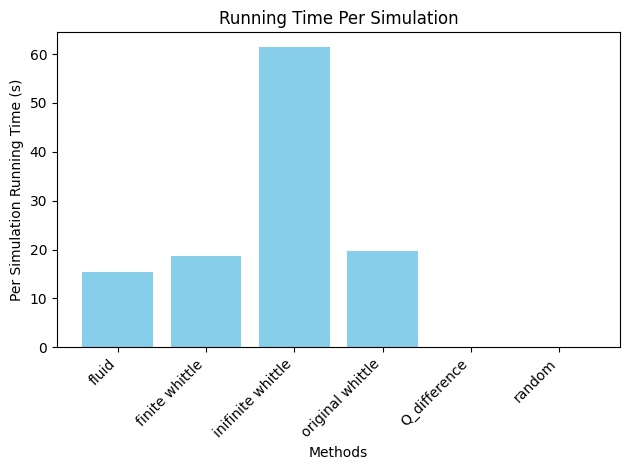

In [7]:
plot_running_time(runningtime_result, N, T, K, group_member_num, 'Poisson')